In [1]:
using Revise
using LowRankVortex
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using ProgressMeter
using Interpolations
using ForwardDiff

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broke

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

In [2]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
        colorbar_tickfontsize = 18,
        colorbar_titlefontsize = 18,
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

In [7]:
?color_palette

search: color_palette get_color_palette



A palette of colors for plotting


In [5]:
c_real_anal = theme_palette(:auto)[11]
c_imag_anal = theme_palette(:auto)[13]

c_real_gram = theme_palette(:auto)[7]
c_imag_gram = theme_palette(:auto)[12]

c_sensors = color_palette[end-1]
c_vortex =  color_palette[2]
c_cluster = LowRankVortex.color_palette[3]

In [29]:
n = 16
ρn = 0.3
zJ = map(j->ρn*exp(2*π*im*j/n), 1:n)
# zJ = [-0.1, 0.0, 0.1]
SJ = 4*π*ones(n)

sources = PotentialFlow.Source.Point.(zJ, SJ)

d = 50
ρd = 3.0
zsensors = 4.0*im .+ collect(range(-10.0, 10.0, length = d));
# zsensors = map(j->ρd*exp(2*π*im*j/d), 1:d);

In [30]:
function evaluate_complexpotential(target, source)
    F = zeros(Complex{Elements.property_type(eltype(source))}, length(target))
    PotentialFlow.Elements.complexpotential!(F, target, source)
    return complex(F)
end

evaluate_complexpotential (generic function with 1 method)

In [31]:
function evaluate_potential(target, source)
    F = zeros(Complex{Elements.property_type(eltype(source))}, length(target))
    PotentialFlow.Elements.complexpotential!(F, target, source)
    return complex(real.(F))
end

evaluate_potential (generic function with 1 method)

In [32]:
function Rx(A::AbstractMatrix{T}, U::AbstractMatrix{S}) where {T<: Number, S<: Number} 
    # Ensure that the basis is orthonormal
    @assert norm(U'*U - I) < 100eps()
    
    n = size(U,2)
    out = zeros(n)
    E = real(tr(U'*A*A'*U))
    for i=1:n
        out[i] = real(tr(U[:,1:i]'*A*A'*U[:,1:i]))
    end
    
    out *= 1/E
    return out
end

# Rx(dϕdx, U)[1:11]-cumsum(Λ.^2)./sum(Λ.^2)

function Ry(A::AbstractMatrix{T}, V::AbstractMatrix{S}) where {T<: Number, S<: Number} 
    # Ensure that the basis is orthonormal
    @assert norm(V'*V - I) < 100eps()
    
    n = size(V,2)
    out = zeros(n)
    E = real(tr(V'*A'*A*V))
    for i=1:n
        out[i] = real(tr(V[:,1:i]'*A'*(A*V[:,1:i])))
    end
    
    out *= 1/E
    return out
end

# Rx(dϕdx, U)[1:11]-cumsum(Λ.^2)./sum(Λ.^2)

Ry (generic function with 1 method)

In [33]:
zc = sum(zJ.*SJ)/sum(SJ)

-1.1043592643970542e-17 - 4.592425496802573e-18im

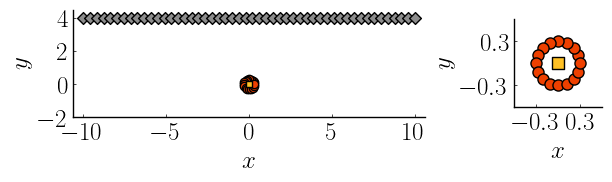

In [34]:
l = Plots.@layout [a{0.8w} b{0.2w}]
plt1 = plot(size = (60, 50))
scatter!(plt1, real.(zJ), imag.(zJ), ratio = 1, ylim = (-2.0, 4.5), legend = false, marker = :circle,
         markersize = 6, yticks = -2:2:4, color = c_vortex)
scatter!(plt1, [0.0], [0.0], marker = :square, color = c_cluster)
scatter!(plt1, real.(zsensors), imag.(zsensors), color = :gray55, markersize = 6, legend = false, 
         markershape = :diamond)

plt2 = plot()
scatter!(plt2, real.(zJ), imag.(zJ), ratio = 1, xlim = (-2*ρn, 2*ρn), ylim = (-2*ρn, 2*ρn), 
         color = c_vortex, legend = false, marker = :circle, markersize = 8, xticks = -ρn:2*ρn:ρn, 
         yticks = -ρn:2*ρn:ρn)
scatter!(plt2, [0.0], [0.0], marker = :square, color = c_cluster, markersize = 8)

plot(plt1, plt2, layout = l, link = :x, xlabel = L"x", ylabel = L"y")
savefig("setup_example1.pdf")

In [35]:
Ftab = zeros(ComplexF64, d)

for J=1:n
    for i=1:d
        Ftab[i] += SJ[J]/(2*π)*log(zsensors[i] - zJ[J])
    end
end

norm(Ftab - complexpotential(zsensors, sources))

2.3898437090739062e-14

In [36]:
ϕ(target, source) = 1/(4*π)*log(norm(target - source)^2)

ϕ (generic function with 1 method)

In [37]:
dFdz, dFdzstar = PotentialFlow.Elements.jacobian_position(x -> evaluate_complexpotential(zsensors, x), sources);

In [38]:
dϕdz, dϕdzstar = PotentialFlow.Elements.jacobian_position(x -> evaluate_potential(zsensors, x), sources);

In [39]:
dϕdx = real(conj(dFdz));

In [40]:
U, Λ, V = svd(dϕdz; full =  true)

SVD{ComplexF64, Float64, Matrix{ComplexF64}}
U factor:
50×50 Matrix{ComplexF64}:
 -0.0722938-0.0251019im  -0.0922094+0.0314604im   …    0.0287847+0.00506769im
 -0.0745387-0.0271028im  -0.0963645+0.0288279im          0.02702+0.0522224im
 -0.0768866-0.0293263im   -0.100688+0.0256682im        -0.165346+0.0742684im
 -0.0793376-0.0318035im   -0.105152+0.0218915im       -0.0585406-0.119689im
 -0.0818898-0.0345706im   -0.109717+0.0173939im         0.117016-0.053087im
 -0.0845376-0.0376693im   -0.114319+0.012056im    …     0.175255+0.0496822im
 -0.0872709-0.0411482im   -0.118866+0.00574278im       -0.165568+0.0870396im
 -0.0900734-0.0450632im   -0.123226-0.00169575im       0.0760224-0.0752559im
 -0.0929194-0.0494786im   -0.127216-0.0104214im       -0.0683677-0.0117669im
 -0.0957714-0.0544674im   -0.130583-0.0206004im         0.173464+0.055595im
 -0.0985752-0.0601119im   -0.132985-0.0323897im   …    -0.286297-0.115065im
  -0.101255-0.0665027im   -0.133967-0.0459131im        -0.049552+0.104467im

In [41]:
multipole = Matrix(hcat(map(i->map(z -> 1/z^i , zsensors), 1:30)...));
Qu = Matrix(qr(multipole).Q);

In [42]:
vander = hcat(map(i->map(z -> z^(i-1) , zJ), 1:30)...);
Qv = Matrix(qr(reverse(vander, dims = 1), Val(false)).Q)

16×16 Matrix{ComplexF64}:
 -0.25+0.0im         -0.25+8.67867e-17im  …         -0.25+8.60423e-16im
 -0.25+0.0im      -0.23097+0.0956709im           -0.23097-0.0956709im
 -0.25+0.0im     -0.176777+0.176777im           -0.176777-0.176777im
 -0.25+0.0im    -0.0956709+0.23097im           -0.0956709-0.23097im
 -0.25+0.0im   1.38778e-17+0.25im            -7.21645e-16-0.25im
 -0.25+0.0im     0.0956709+0.23097im      …     0.0956709-0.23097im
 -0.25+0.0im      0.176777+0.176777im            0.176777-0.176777im
 -0.25+0.0im       0.23097+0.0956709im            0.23097-0.0956709im
 -0.25+0.0im          0.25-2.42861e-17im             0.25-5.06539e-16im
 -0.25+0.0im       0.23097-0.0956709im            0.23097+0.0956709im
 -0.25+0.0im      0.176777-0.176777im     …      0.176777+0.176777im
 -0.25+0.0im     0.0956709-0.23097im            0.0956709+0.23097im
 -0.25+0.0im  -5.20417e-17-0.25im             3.33067e-16+0.25im
 -0.25+0.0im    -0.0956709-0.23097im           -0.0956709+0.23097im
 -0.25+0.0i

In [43]:
@show norm(-multipole*transpose(vander)*Diagonal(SJ/(2*π))-dFdz)
@show norm(-0.5*multipole*transpose(vander)*Diagonal(SJ/(2*π))-dϕdz)
@show norm((-real(multipole)*real(vander)'+imag(multipole)*imag(vander)')*Diagonal(SJ/(2*π))-dϕdx);

norm(-multipole * transpose(vander) * Diagonal(SJ / (2π)) - dFdz) = 2.252129185205858e-15
norm(-0.5 * multipole * transpose(vander) * Diagonal(SJ / (2π)) - dϕdz) = 1.126064592602929e-15
norm((-(real(multipole)) * (real(vander))' + imag(multipole) * (imag(vander))') * Diagonal(SJ / (2π)) - dϕdx) = 1.0851278161083773e-15


In [44]:
cumsum(Λ.^2)./sum(Λ.^2)

16-element Vector{Float64}:
 0.9987027800081517
 0.9999983499868748
 0.9999999979294273
 0.9999999999974244
 0.999999999999997
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002

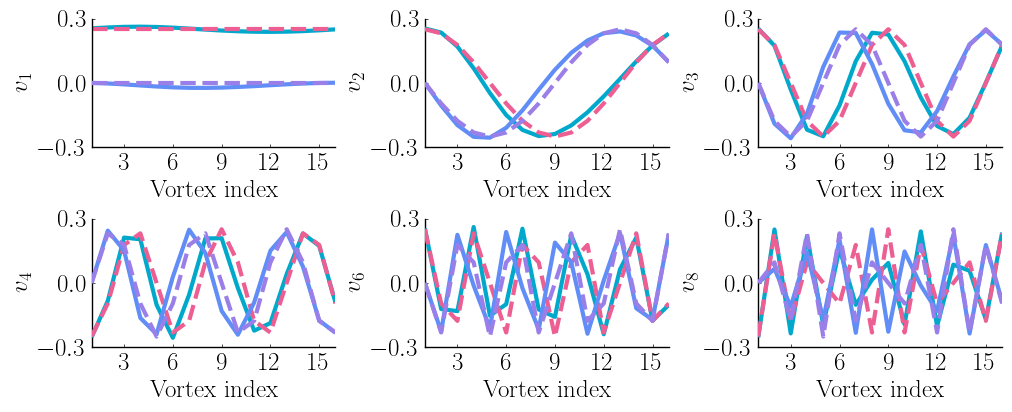

In [45]:
# plt = 

plt1 = plot(layout = grid(2,3), xlabel = string("Vortex index"), xlim = (-Inf, Inf), ylim = (-0.3, 0.3), yticks = collect(-0.3:0.3:0.3), 
            size = (1000, 400), legend = false)#, xticks = 1:2:n)

# First plot 
plot!(plt1[1, 1], real(-V[:,1]), ylabel = L"v_1", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 1], real(-Qv[:,1]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 1], imag(-V[:,1]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 1], imag(-Qv[:,1]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)


# Second plot
plot!(plt1[1, 2], real(V[:,2]), ylabel = L"v_2", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 2], real(-Qv[:,2]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 2], imag(V[:,2]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 2], imag(-Qv[:,2]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Third plot
plot!(plt1[1, 3], real(V[:,3]), ylabel = L"v_3", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 3], real(Qv[:,3]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 3], imag(V[:,3]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 3], imag(Qv[:,3]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Fourth plot
plot!(plt1[2, 1], real(V[:,4]), ylabel = L"v_4", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 1], real(-Qv[:,4]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 1], imag(V[:,4]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 1], imag(-Qv[:,4]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# # Eight  plot
plot!(plt1[2, 2], real(V[:,6]), ylabel = L"v_6", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 2], real(Qv[:,6]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 2], imag(V[:,6]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 2], imag(Qv[:,6]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Eleventh  plot
plot!(plt1[2, 3], real(V[:,8]), ylabel = L"v_{8}", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 3], real(Qv[:,8]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 3], imag(V[:,8]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 3], imag(Qv[:,8]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# plt2 = plot(xlim = (0.1, 0.2), ylim = (0.0, 0.1), xaxis = false, yaxis = false, legend = :bottom, size = (50, 20))

# plot!(plt2, zeros(2), linewidth = 3, 
#       label = L"Re(U(\nabla_{\textbf{\textit{z}}} \textbf{\textit{h}})[:,i])", color = c_real_anal)
# plot!(plt2, zeros(2), linewidth = 3, 
#       label = L"Re({\textbf{\textit{Q}}}_{\textbf{\textit{z}}}[:,i])", color = c_real_gram, linestyle = :dash)
# plot!(plt2, zeros(2), linewidth = 3, 
#       label = L"Im(U(\nabla_{\textbf{\textit{z}}} \textbf{\textit{h}})[:,i])", color = c_imag_anal)
# plot!(plt2, zeros(2), linewidth = 3, 
#       label = L"Im({\textbf{\textit{Q}}}_{\textbf{\textit{z}}}[:,i])", color = c_imag_gram, linestyle = :dash)

# plot(plt1, plt2)
savefig("real_imag_v_modes_source_potential.pdf")

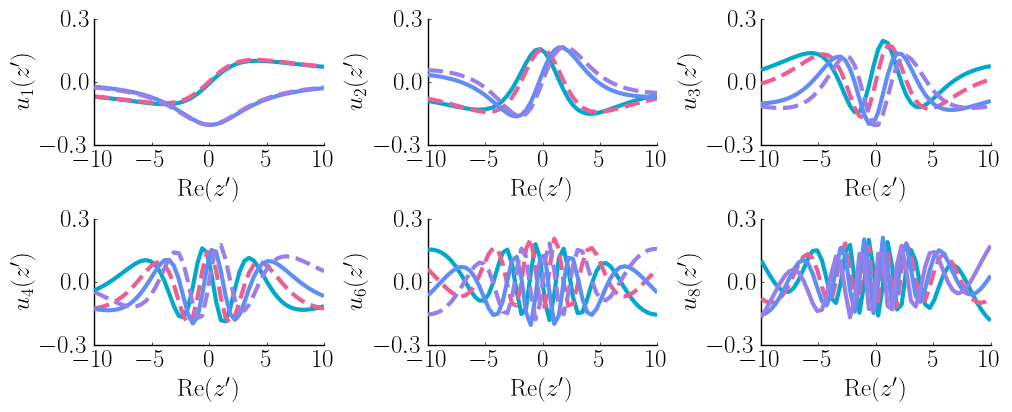

In [46]:
# plt = 

plt1 = plot(layout = grid(2,3), xlabel = string("Re")*L"(z^\prime)", xlim = (-Inf, Inf), ylim = (-0.3, 0.3), 
            size = (1000, 400), legend = false, yticks = (-0.3:0.3:0.3))

# First plot 
plot!(plt1[1, 1], real.(zsensors), real(U[:,1]), ylabel = L"u_1(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 1], real.(zsensors), real(Qu[:,1]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 1], real.(zsensors), imag(U[:,1]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 1], real.(zsensors), imag(Qu[:,1]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)


# Second plot
plot!(plt1[1, 2], real.(zsensors), real(U[:,2]), ylabel = L"u_2(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 2], real.(zsensors), real(Qu[:,2]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 2], real.(zsensors), imag(U[:,2]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 2], real.(zsensors), imag(Qu[:,2]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Third plot
plot!(plt1[1, 3], real.(zsensors), real(U[:,3]), ylabel = L"u_3(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 3], real.(zsensors), real(-Qu[:,3]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 3], real.(zsensors), imag(U[:,3]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 3], real.(zsensors), imag(-Qu[:,3]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Fourth plot
plot!(plt1[2, 1], real.(zsensors), real(U[:,4]), ylabel = L"u_4(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 1], real.(zsensors), real(Qu[:,4]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 1], real.(zsensors), imag(U[:,4]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 1], real.(zsensors), imag(Qu[:,4]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# # Eight  plot
plot!(plt1[2, 2], real.(zsensors), real(U[:,6]), ylabel = L"u_6(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 2], real.(zsensors), real(Qu[:,6]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 2], real.(zsensors), imag(U[:,6]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 2], real.(zsensors), imag(-Qu[:,6]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Eleventh  plot
plot!(plt1[2, 3], real.(zsensors), real(U[:,8]), ylabel = L"u_{8}(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 3], real.(zsensors), real(-Qu[:,8]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 3], real.(zsensors), imag(-U[:,8]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 3], real.(zsensors), imag(Qu[:,8]), linewidth = 3, linestyle = :auto, 
      color = c_imag_gram)

savefig("real_imag_u_modes_target_potential.pdf")

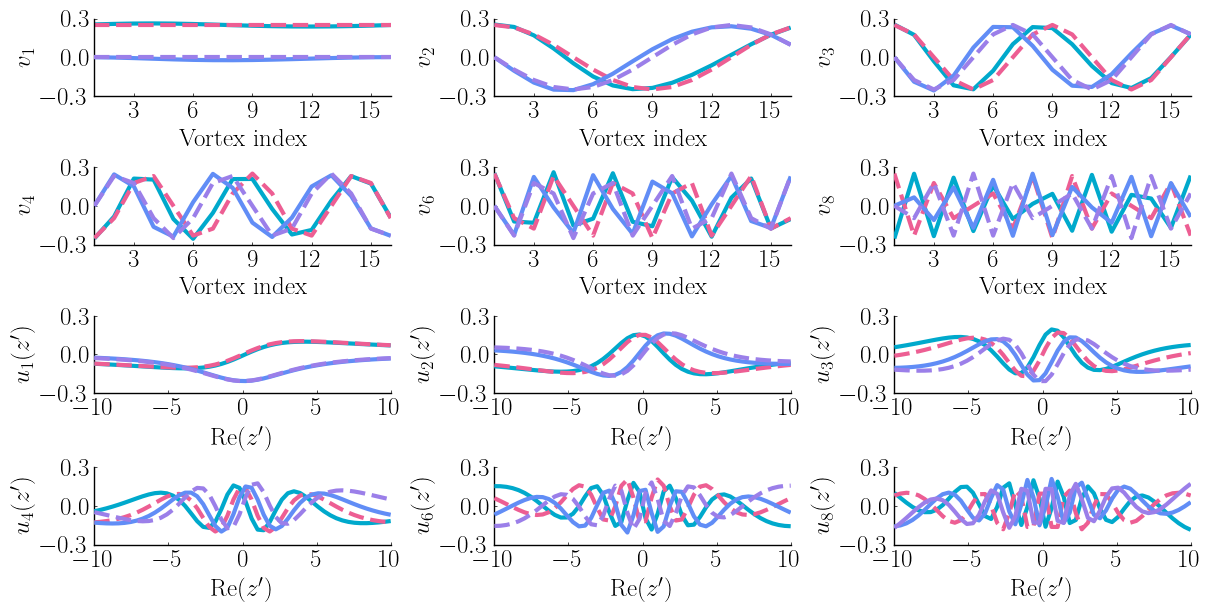

In [47]:
plt1 = plot(layout = grid(4,3), xlim = (-Inf, Inf), ylim = (-0.3, 0.3), 
            size = (1200, 600), legend = false,  yticks = collect(-0.3:0.3:0.3))

annotationlist = [L"(a)" L"(b)" L"(c)"; 
                  L"(d)" L"(e)" L"(f)"; 
                  L"(a^\prime)" L"(b^\prime)" L"(c^\prime)"; 
                  L"(d^\prime)" L"(e^\prime)" L"(f^\prime)"; ]

xlist = Int64.(Matrix(hcat(map(i-> i*ones(3), 1:4)...)'))
ylist = Int64.(repeat(collect(1:3)', 4, 1))

for i=1:2
    for j=1:3
        plot!(plt1[i,j], xlabel = string("Vortex index"))
#         annotate!(plt1[xlist[i,j],ylist[i,j]],  )
    end
end

for i=3:4
    for j=1:3
    plot!(plt1[i,j], xlabel = string("Re")*L"(z^\prime)")
    end
end


# First plot 
plot!(plt1[1, 1], real(-V[:,1]), ylabel = L"v_1", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 1], real(-Qv[:,1]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 1], imag(-V[:,1]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 1], imag(-Qv[:,1]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)


# Second plot
plot!(plt1[1, 2], real(V[:,2]), ylabel = L"v_2", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 2], real(-Qv[:,2]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 2], imag(V[:,2]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 2], imag(-Qv[:,2]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Third plot
plot!(plt1[1, 3], real(V[:,3]), ylabel = L"v_3", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[1, 3], real(Qv[:,3]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[1, 3], imag(V[:,3]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[1, 3], imag(Qv[:,3]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Fourth plot
plot!(plt1[2, 1], real(V[:,4]), ylabel = L"v_4", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 1], real(-Qv[:,4]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 1], imag(V[:,4]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 1], imag(-Qv[:,4]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# # Eight  plot
plot!(plt1[2, 2], real(V[:,6]), ylabel = L"v_6", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 2], real(Qv[:,6]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 2], imag(V[:,6]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 2], imag(Qv[:,6]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Eleventh  plot
plot!(plt1[2, 3], real(V[:,8]), ylabel = L"v_{8}", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[2, 3], real(-Qv[:,8]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[2, 3], imag(V[:,8]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[2, 3], imag(-Qv[:,8]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)


###### Observation space

# First plot 
plot!(plt1[3, 1], real.(zsensors), real(U[:,1]), ylabel = L"u_1(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[3, 1], real.(zsensors), real(Qu[:,1]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[3, 1], real.(zsensors), imag(U[:,1]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[3, 1], real.(zsensors), imag(Qu[:,1]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)


# Second plot
plot!(plt1[3, 2], real.(zsensors), real(U[:,2]), ylabel = L"u_2(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[3, 2], real.(zsensors), real(Qu[:,2]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[3, 2], real.(zsensors), imag(U[:,2]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[3, 2], real.(zsensors), imag(Qu[:,2]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Third plot
plot!(plt1[3, 3], real.(zsensors), real(U[:,3]), ylabel = L"u_3(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[3, 3], real.(zsensors), real(-Qu[:,3]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[3, 3], real.(zsensors), imag(U[:,3]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[3, 3], real.(zsensors), imag(-Qu[:,3]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Fourth plot
plot!(plt1[4, 1], real.(zsensors), real(U[:,4]), ylabel = L"u_4(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[4, 1], real.(zsensors), real(Qu[:,4]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[4, 1], real.(zsensors), imag(U[:,4]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[4, 1], real.(zsensors), imag(Qu[:,4]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# # Eight  plot
plot!(plt1[4, 2], real.(zsensors), real(U[:,6]), ylabel = L"u_6(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[4, 2], real.(zsensors), real(Qu[:,6]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[4, 2], real.(zsensors), imag(U[:,6]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[4, 2], real.(zsensors), imag(-Qu[:,6]), linewidth = 3, linestyle = :dash, 
      color = c_imag_gram)

# Eleventh  plot
plot!(plt1[4, 3], real.(zsensors), real(U[:,8]), ylabel = L"u_{8}(z^\prime)", linewidth = 3, 
      color = c_real_anal)
plot!(plt1[4, 3], real.(zsensors), real(Qu[:,8]), linewidth = 3, linestyle = :dash, 
      color = c_real_gram)
plot!(plt1[4, 3], real.(zsensors), imag(-U[:,8]), linewidth = 3, linestyle = :solid,
      color = c_imag_anal)
plot!(plt1[4, 3], real.(zsensors), imag(Qu[:,8]), linewidth = 3, linestyle = :auto, 
      color = c_imag_gram)

savefig("example1_modes.pdf")

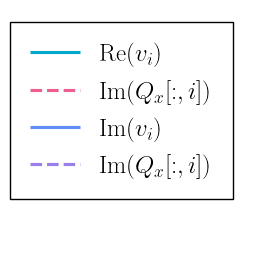

In [48]:
plt = plot([0 0 0 0], label = "", xlim = (0.0, 0.0), ylim = (0.0, 0.0), axis = false, size = (130, 250))
# plot!(plt, zeros(2), linewidth = 3, 
#       label = "Re"*L"(V(\nabla_{z} \textbf{\textit{h}})[:,i])", color = c_real_anal)
# plot!(plt, zeros(2), linewidth = 3, 
#       label = "Im"*L"(Q_{z}[:,i])", color = c_real_gram, linestyle = :dash)
# plot!(plt, zeros(2), linewidth = 3, 
#       label = "Im"*L"(V(\nabla_{z} \textbf{\textit{h}})[:,i])", color = c_imag_anal)
# plot!(plt, zeros(2), linewidth = 3, 
#       label = "Im"*L"(Q_{z}[:,i])", color = c_imag_gram, linestyle = :dash)
# savefig("legend_u_modes_source_potential.pdf")

plot!(plt, zeros(2), linewidth = 3, 
      label = "Re"*L"(v_i)", color = c_real_anal)
plot!(plt, zeros(2), linewidth = 3, 
      label = "Im"*L"(Q_{x}[:,i])", color = c_real_gram, linestyle = :dash)
plot!(plt, zeros(2), linewidth = 3, 
      label = "Im"*L"(v_i)", color = c_imag_anal)
plot!(plt, zeros(2), linewidth = 3, 
      label = "Im"*L"(Q_{x}[:,i])", color = c_imag_gram, linestyle = :dash)
savefig("legend_v_modes_source_potential.pdf")

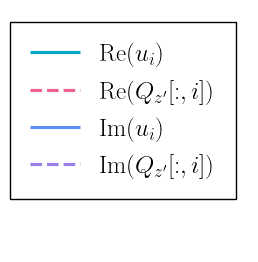

In [49]:
plt = plot([0 0 0 0], label = "", xlim = (0.0, 0.0), ylim = (0.0, 0.0), axis = false, size = (130, 250))

# plot!(plt, zeros(2), linewidth = 3, 
#       label = "Re"*L"(U(\nabla_{\textbf{\textit{z}}} \textbf{\textit{h}})[:,i])", color = c_real_anal)
# plot!(plt, zeros(2), linewidth = 3, 
#       label = "Re"*L"({Q}_{\xi}[:,i])", color = c_real_gram, linestyle = :dash)
# plot!(plt, zeros(2), linewidth = 3, 
#       label = "Im"*L"(U(\nabla_{\textbf{\textit{z}}} \textbf{\textit{h}})[:,i])", color = c_imag_anal)
# plot!(plt, zeros(2), linewidth = 3, 
#       label = "Im"*L"(Q_{\xi}[:,i])", color = c_imag_gram, linestyle = :dash)
# savefig("legend_v_modes_target_potential.pdf")

plot!(plt, zeros(2), linewidth = 3, 
      label = "Re"*L"(u_i)", color = c_real_anal)
plot!(plt, zeros(2), linewidth = 3, 
      label = "Re"*L"({Q}_{z^\prime}[:,i])", color = c_real_gram, linestyle = :dash)
plot!(plt, zeros(2), linewidth = 3, 
      label = "Im"*L"(u_i)", color = c_imag_anal)
plot!(plt, zeros(2), linewidth = 3, 
      label = "Im"*L"(Q_{z^\prime}[:,i])", color = c_imag_gram, linestyle = :dash)
savefig("legend_u_modes_target_potential.pdf")

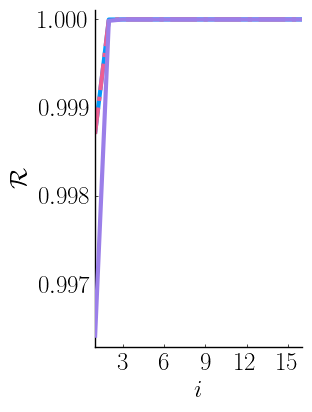

In [50]:
plt = plot(legend = false, xlabel = L"i",
           xlims = (-Inf, Inf), size = (300, 400))

plot!(plt[1,1], 1:min(n,d), Rx(dϕdz, U)[1:min(n,d)], linewidth = 3, ylabel = L"\mathcal{R}")
plot!(plt[1,1], 1:min(n,d), Rx(dϕdz, Qu)[1:min(n,d)], linewidth = 3, color = c_real_gram, linestyle = :dashdot)
plot!(plt[1,1], 1:min(n,d), Ry(dϕdz, Qv)[1:min(n,d)], linewidth = 3, color = c_imag_gram)
savefig("rayleigh_quotient_source.pdf")